In [3]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [4]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2022-06-25 02:23:15--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.192.143, 2600:140e:6:ba1::e59, 2600:140e:6:b8d::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.220.192.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   155MB/s    in 5.0s    

2022-06-25 02:23:21 (156 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [5]:
l='/tmp/cats-and-dogs.zip'
z=zipfile.ZipFile(l,'r')
z.extractall('/tmp')
z.close()

In [6]:
s='/tmp/PetImages'
d=os.path.join(s,'Dog')
c=os.path.join(s,'Cat')

In [7]:
r='/tmp/cats-v-dogs'
os.makedirs(r)

if os.path.exists(r):
  shutil.rmtree(r)

def tv(r):

  t=os.path.join(r,'training')
  os.makedirs(t)
  v=os.path.join(r,'validation')
  os.makedirs(v)

  tc=os.path.join(t,'cats')
  os.makedirs(tc)
  td=os.path.join(t,'dogs')
  os.makedirs(td)

  vc=os.path.join(v,'cats')
  os.makedirs(vc)
  vd=os.path.join(v,'dogs')
  os.makedirs(vd)

tv(r)

In [8]:
for rootdirs,dirs,files in os.walk(r):
  for subdir in dirs:
    print(os.path.join(r,subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/cats
/tmp/cats-v-dogs/dogs
/tmp/cats-v-dogs/cats
/tmp/cats-v-dogs/dogs


In [9]:
def sd(s,t,v,p):
  sfl=random.sample(os.listdir(s),len(os.listdir(s)))
  tn=int(len(sfl)*p)

  i=0
  tr=t

  for item in sfl:
    its=os.path.join(s,item)
    if os.path.getsize(its)==0:
      print(f'{item} is zero length, so ignoring')
    else:
      copyfile(its,os.path.join(tr,item))
      i+=1
    
    if i==tn:
      tr=v
  pass

In [10]:
c='/tmp/PetImages/Cat/'
d='/tmp/PetImages/Dog/'

t='/tmp/cats-v-dogs/training/'
v='/tmp/cats-v-dogs/validation/'

tc=os.path.join(t,'cats')
td=os.path.join(t,'dogs')

vc=os.path.join(v,'cats')
vd=os.path.join(v,'dogs')

if len(os.listdir(tc))>0:
  for file in os.scandir(tc):
    os.remove(file.path)
if len(os.listdir(td))>0:
  for file in os.scandir(td):
    os.remove(file.path)
if len(os.listdir(vc))>0:
  for file in os.scandir(vc):
    os.remove(file.path)
if len(os.listdir(vd))>0:
  for file in os.scandir(vd):
    os.remove(file.path)
p=0.9

sd(c,tc,vc,p)
sd(d,td,vd,p)

print(f'Cats Training image count : {len(os.listdir(tc))}')
print(f'Dogs Training image count : {len(os.listdir(td))}')
print(f'Cats Validation image count : {len(os.listdir(vc))}')
print(f'Dogs Validation image count : {len(os.listdir(vd))}')

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring
Cats Training image count : 11250
Dogs Training image count : 11250
Cats Validation image count : 1250
Dogs Validation image count : 1250


In [11]:
tcn=os.listdir(tc)
tdn=os.listdir(td)

vcn=os.listdir(vc)
vdn=os.listdir(vd)

%matplotlib inline

import matplotlib.image as mim
import matplotlib.pyplot as plt

r=4
c=4
z=0

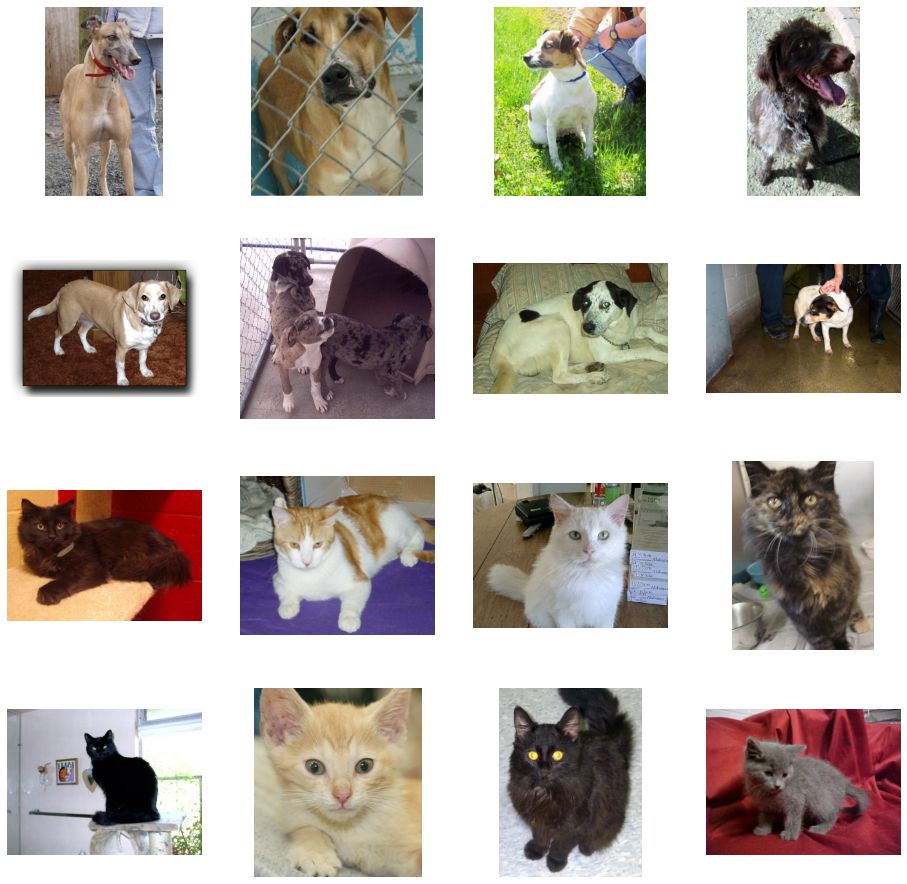

In [12]:
f=plt.gcf()
f.set_size_inches(c*4,r*4)

z+=8

ncp=[os.path.join(tc,f) for f in tcn[z-8:z]]
ndp=[os.path.join(td,f) for f in tdn[z-8:z]]

for i,im in enumerate(ndp+ncp):
  s=plt.subplot(r,c,i+1)
  s.axis('Off')

  img=mim.imread(im)
  plt.imshow(img)

In [13]:
def tvg(t,v):

  td=ImageDataGenerator(rescale=1./255,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')
  
  tg=td.flow_from_directory(directory=t,
                            batch_size=20,
                            class_mode='binary',
                            target_size=(150,150))
  
  vd=ImageDataGenerator(rescale=1.0/255.)

  vg=vd.flow_from_directory(directory=v,
                            batch_size=20,
                            class_mode='binary',
                            target_size=(150,150))
  
  return tg,vg

In [14]:
from tensorflow.keras.optimizers import RMSprop
tg,vg= tvg(t,v)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
def cm():
  model=tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')
])
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [16]:
model=cm()
hist=model.fit(tg,
               epochs=15,
               verbose=1,
               validation_data=vg)

Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6125

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 654s 580ms/step - loss: 0.6574 - accuracy: 0.6125 - val_loss: 0.5545 - val_accuracy: 0.7092
Epoch 2/15
1125/1125 [==============================] - 654s 582ms/step - loss: 0.5921 - accuracy: 0.6885 - val_loss: 0.4728 - val_accuracy: 0.7780
Epoch 3/15
1125/1125 [==============================] - 653s 580ms/step - loss: 0.5570 - accuracy: 0.7204 - val_loss: 0.4644 - val_accuracy: 0.7876
Epoch 4/15
1125/1125 [==============================] - 658s 585ms/step - loss: 0.5274 - accuracy: 0.7406 - val_loss: 0.4309 - val_accuracy: 0.8080
Epoch 5/15
1125/1125 [==============================] - 653s 580ms/step - loss: 0.4924 - accuracy: 0.7691 - val_loss: 0.3908 - val_accuracy: 0.8308
Epoch 6/15
1125/1125 [==============================] - 647s 575ms/step - loss: 0.4747 - accuracy: 0.7811 - val_loss: 0.3598 - val_accuracy: 0.8524
Epoch 7/15
1125/1125 [==============================] - 644s 572ms/step - loss: 0.4579 - accuracy: 0.7948 - val_loss: 0.402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


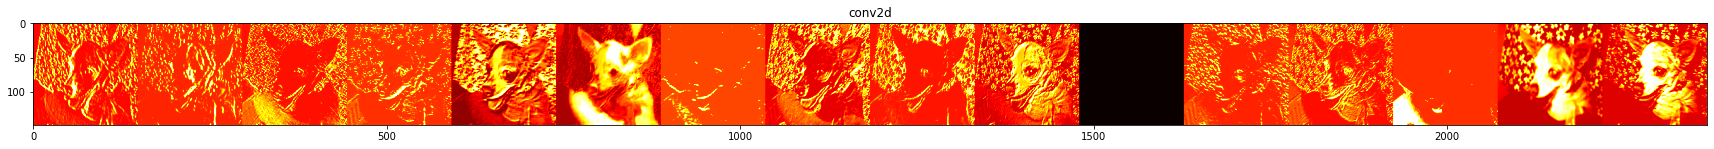

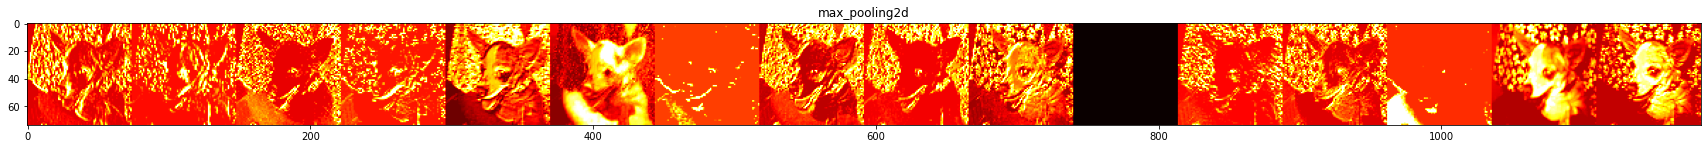

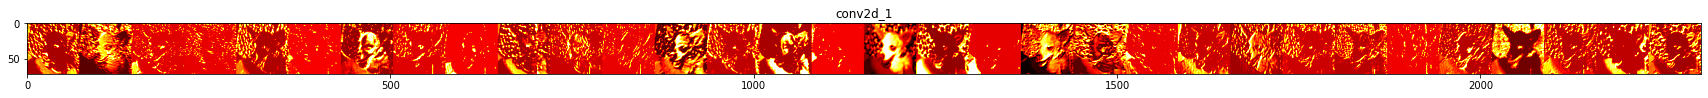

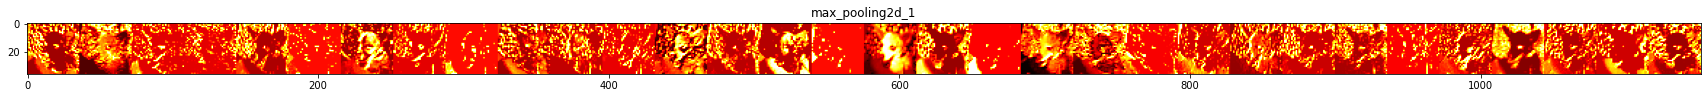

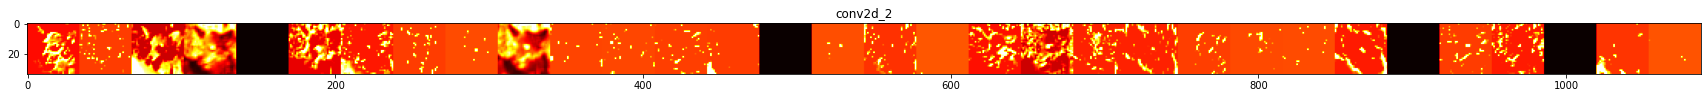

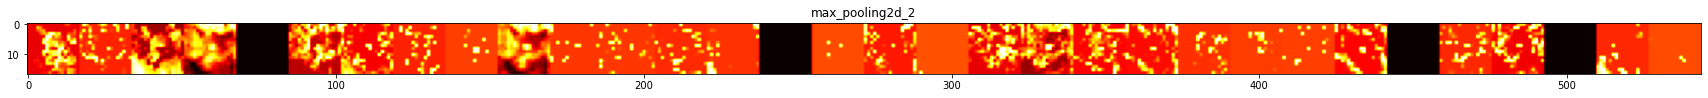

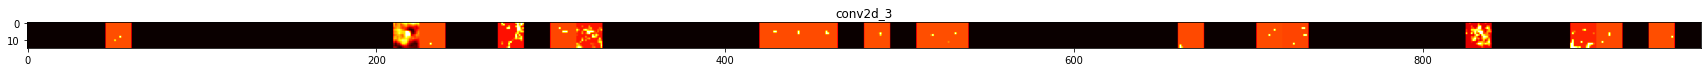

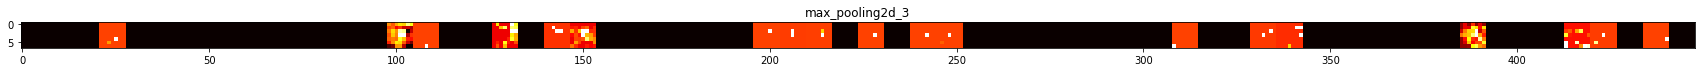

In [19]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image

so=[layer.output for layer in model.layers]
vm=tf.keras.models.Model(inputs=model.input,outputs=so)

ci=[os.path.join(tc,f) for f in tcn]
di=[os.path.join(td,f) for f in tdn]
ip=random.choice(ci+di)

img=image.load_img(ip,target_size=(150,150))
x=image.img_to_array(img)
x=x.reshape((1,)+x.shape)
x/=255.0

sfm=vm.predict(x)
lns=[layer.name for layer in model.layers]

for ln,fm in zip(lns,sfm):
  if len(fm.shape)==4:
    nf=fm.shape[-1]
    s=fm.shape[1]

    dg=np.zeros((s,s*nf))
    for i in range(nf):
      x=fm[0,:,:,i]
      x-=x.mean()
      x/=x.std()
      x*=64
      x+=128
      x=np.clip(x,0,255).astype('uint8')
      dg[:,i*s:(i+1)*s]=x

    sc=30.0/nf
    plt.figure(figsize=(sc*nf,sc))
    plt.title(ln)
    plt.grid(False)
    plt.imshow(dg,aspect='auto',cmap='hot')   

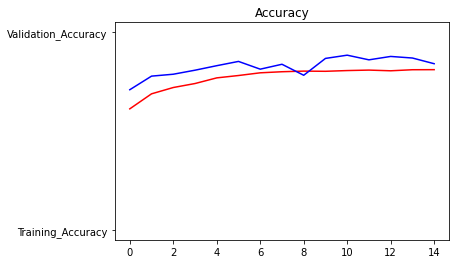

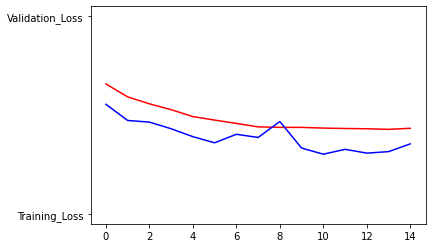

In [20]:
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r','Training_Accuracy')
plt.plot(epochs,val_acc,'b','Validation_Accuracy')
plt.title('Accuracy')
plt.show()

print('')

plt.plot(epochs,loss,'r','Training_Loss')
plt.plot(epochs,val_loss,'b','Validation_Loss')
plt.show()

In [21]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

u=files.upload()

for fn in u.keys():
  p='/content/'+fn
  img=image.load_img(p,target_size=(150,150))
  x=image.img_to_array(img)
  x/=255
  x=np.expand_dims(x,axis=0)
  images=np.vstack([x])
  classes=model.predict(images,batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn+' is a dog')
  else:
    print(fn+' is a cat')

Saving edited3.jpg to edited3.jpg
[0.9381147]
edited3.jpg is a dog
